In [1]:
# Libraries
import numpy as np
import pandas as pd
import gym
from tqdm import tqdm
import collections

import sys
sys.path.append('../')

# RL Agents
from agents.monte_carlo_exploring_starts_agent import MonteCarloExploringStartsAgent
from agents.q_learning_agent import QLearningAgent
from agents.expected_sarsa_agent import ExpectedSarsaAgent

# Planning
from agents.dyna_q_agent import DynaQAgent
from agents.dyna_q_plus_agent import DynaQPlusAgent

# Visualization
from frozen_lake_plots import plot_frozen_lake, plot_state_action_frozen_lake

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("talk")
plt.rcParams["figure.figsize"] = (12, 8)

# Frozen Lake
Notebook containing all agents for the FrozenLake-v1 environment.

## Environment Setup

In [2]:
# Environment
env = gym.make("FrozenLake8x8-v1")
terminal_states = [19, 29, 35, 41, 42, 46, 49, 52, 54, 59, 63]
size = (8, 8)

# Number of runs and episodes per run
num_runs = 100
num_episodes = 15000


## Auxiliary Functions

In [3]:
# Decay LR (Used for epsilon gready)
def decayed_learning_rate(step, initial_learning_rate=1, decay_rate=1e-4, decay_steps=num_episodes):
  return initial_learning_rate * decay_rate ** (step / decay_steps)

In [4]:
# Train a given model
def train_agent(env, agent_class, agent_info, terminal_states, exploring_starts = False, decay_lr = False, decay_exploration = False):

    # Record num steps and rewards 
    all_num_steps = []
    all_rewards = []
    rewards_per_episode = []

    # Summary table for each run
    all_q = []

    # Iterate
    for _ in tqdm(range(num_runs)):
        
        # Initialize Agent
        agent = agent_class(agent_info)

        num_steps = 0
        total_reward = 0

        cache_num_steps = []
        cache_rewards = []

        for num_episode in range(num_episodes):

            # Reset env
            env.reset()


            # Set lr and epsilon
            if decay_lr:
                agent.alpha = decayed_learning_rate(num_episode, initial_learning_rate=0.5, decay_rate=0.01, decay_steps=num_episodes)
            if decay_exploration:
                agent.epsilon = decayed_learning_rate(num_episode, initial_learning_rate=1, decay_rate=1e-4, decay_steps=num_episodes)

            if exploring_starts:
                # Select a random start
                state = env.observation_space.sample()
                while state in terminal_states: # Fix if starting state is terminal
                    state = env.observation_space.sample()

                # Change initial state
                env = env.unwrapped
                env.s = state
            else:
                state = env.s

            # Initial action
            action = agent.agent_start(state)
            done = False

            episode_len = 0
            episode_reward = 0

            while not done:

                # Hardstop for MC
                episode_len += 1
                if episode_len >= 200:
                    done = True
                    break

                new_state, reward, done, _ = env.step(action)

                # Update values
                num_steps += 1
                total_reward += reward
                episode_reward += reward

                cache_num_steps.append(num_steps)
                cache_rewards.append(total_reward)

                if done:
                    break

                new_action = agent.agent_step(reward, new_state)

                # Update state and action
                state, action = new_state, new_action

            # Last agent step
            agent.agent_end(reward)
            rewards_per_episode.append(episode_reward)


        # Append summary table
        all_q.append(agent.create_summary_table())

        # Add rewards and steps
        all_num_steps.append(cache_num_steps)
        all_rewards.append(cache_rewards)

    return all_num_steps, all_rewards, rewards_per_episode, all_q


In [5]:
def plot_performance(all_num_steps, all_rewards):

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 8), tight_layout=True)

    # All plots
    for steps, rewards in zip(all_num_steps, all_rewards):
        ax1.plot(steps, rewards)


    for steps, rewards in zip(all_num_steps, all_rewards):
        ax2.plot(steps, rewards, alpha=0.08, color="black")

    min_len = min([len(l) for l in all_num_steps])
    truncated_all_rewards = [a[:min_len] for a in all_rewards]

    ax2.plot(np.arange(min_len), np.array(truncated_all_rewards).mean(axis=0), color='blue')
        
    ax1.set_title("Agent's Performance")
    ax1.set_xlabel("Time steps")
    ax1.set_ylabel("Comulative Reward")

    ax2.set_title("Agent's Average Performance")
    ax2.set_xlabel("Time steps")
    ax2.set_ylabel("Comulative Reward")

    plt.show()

In [6]:
# Test Policies
def test_policies(model_results, num_games = 10000):

    all_policies = set()
    policy_scores = {}

    for q in model_results["all_q"]:
        all_policies.add(tuple(q["optimal_action"]))

    for policy in tqdm(all_policies):

        # Define the policy as a dict
        policy_dict = dict(zip(range(len(list(policy))), policy))

        # Initialize total reward
        total_reward = 0

        for _ in range(num_games):

            # Reset env
            env.reset()
            state = env.s
            done = False

            while not done:

                action = policy_dict[state]
                state, reward, done, _ = env.step(action)
                
                # Update reward
                total_reward += reward

        policy_scores[policy] = total_reward

    return dict(sorted(policy_scores.items(), key=lambda item: item[1], reverse=True))

In [7]:
def get_q_from_policy(model_results, policy):
    for q in model_results["all_q"]:
        if list(q["optimal_action"])==list(policy.values()):
            return q

## Learning Algorithms

### Monte Carlo Exploring Starts Agent

In [8]:
# Parameters
gamma = 1

# Agent information
agent_class = MonteCarloExploringStartsAgent
agent_info = {"num_actions": env.action_space.n, 
              "num_states": env.observation_space.n, 
              "gamma": gamma}

# Monte Carlo Exploring Starts results
monte_carlo_results = {}

# Train Agent
monte_carlo_results["all_num_steps"], monte_carlo_results["all_rewards"], monte_carlo_results["rewards_per_episode"], monte_carlo_results["all_q"] = train_agent(env, agent_class, agent_info, terminal_states, exploring_starts = True)

100%|██████████| 100/100 [1:00:17<00:00, 36.18s/it]


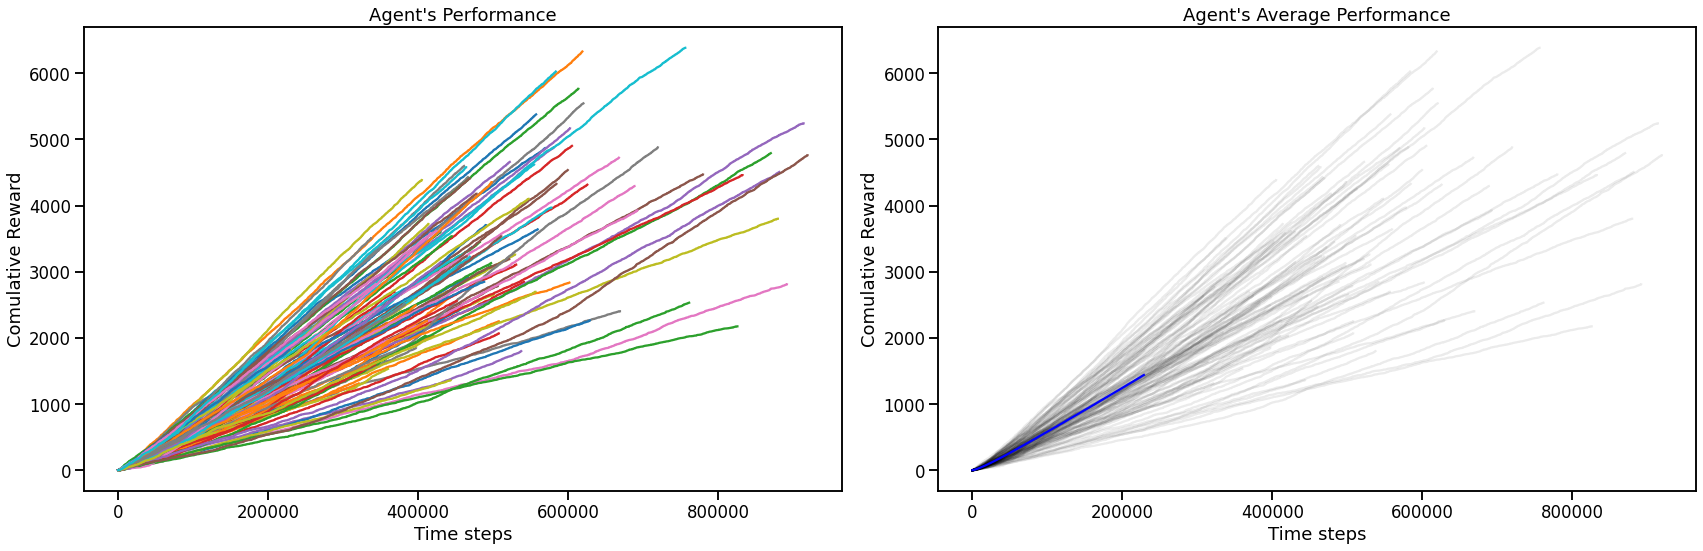

In [9]:
plot_performance(monte_carlo_results["all_num_steps"], monte_carlo_results["all_rewards"])

In [10]:
# Get top policy and state-action values
monte_carlo_policy_performance = test_policies(monte_carlo_results)

monte_carlo_top_policy = dict(zip(range(len(list(monte_carlo_policy_performance)[0])),list(monte_carlo_policy_performance)[0]))
monte_carlo_sample_q = get_q_from_policy(monte_carlo_results, monte_carlo_top_policy)

100%|██████████| 100/100 [11:12<00:00,  6.73s/it]


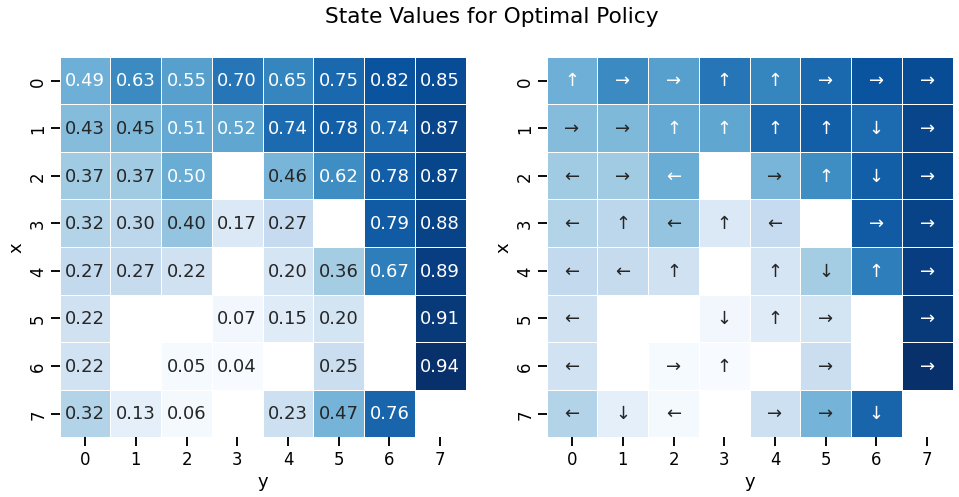

In [11]:
# State values plot
plot_frozen_lake(monte_carlo_sample_q, terminal_states = terminal_states, size = size)

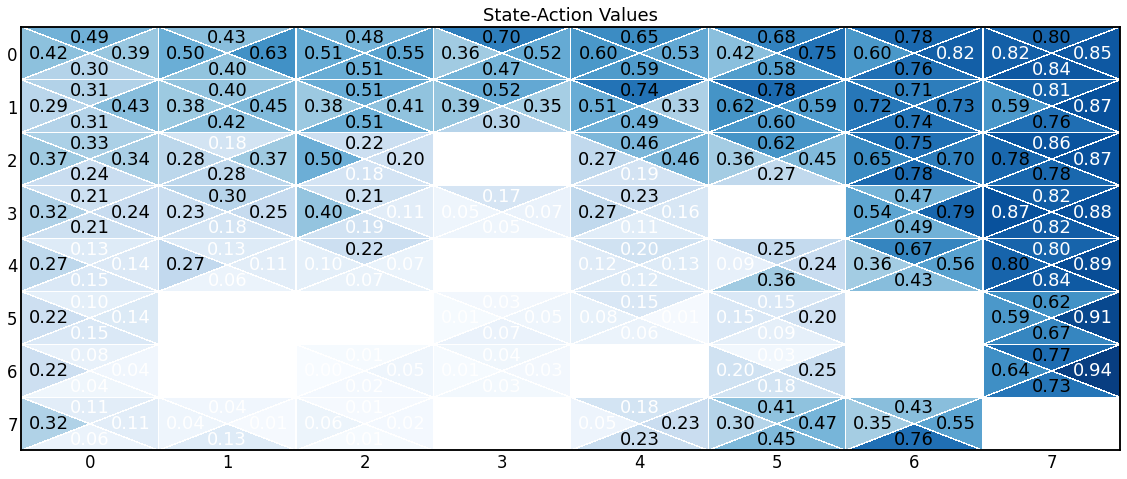

In [12]:
# State-Action values
plot_state_action_frozen_lake(monte_carlo_sample_q, terminal_states = terminal_states, size = size)

### Q-Learning Agent

In [13]:
# Parameters
epsilon = 0.2
alpha = 0.1
gamma = 0.99

# Agent information
agent_class = QLearningAgent
agent_info = {"num_actions": env.action_space.n, 
              "num_states": env.observation_space.n, 
              "epsilon": epsilon, 
              "alpha": alpha, 
              "gamma": gamma}

# Monte Carlo Exploring Starts results
q_learning_results = {}

# Train Agent
q_learning_results["all_num_steps"], q_learning_results["all_rewards"], q_learning_results["rewards_per_episode"], q_learning_results["all_q"] = train_agent(env, agent_class, agent_info, terminal_states, decay_exploration = True)

100%|██████████| 100/100 [1:14:44<00:00, 44.85s/it]


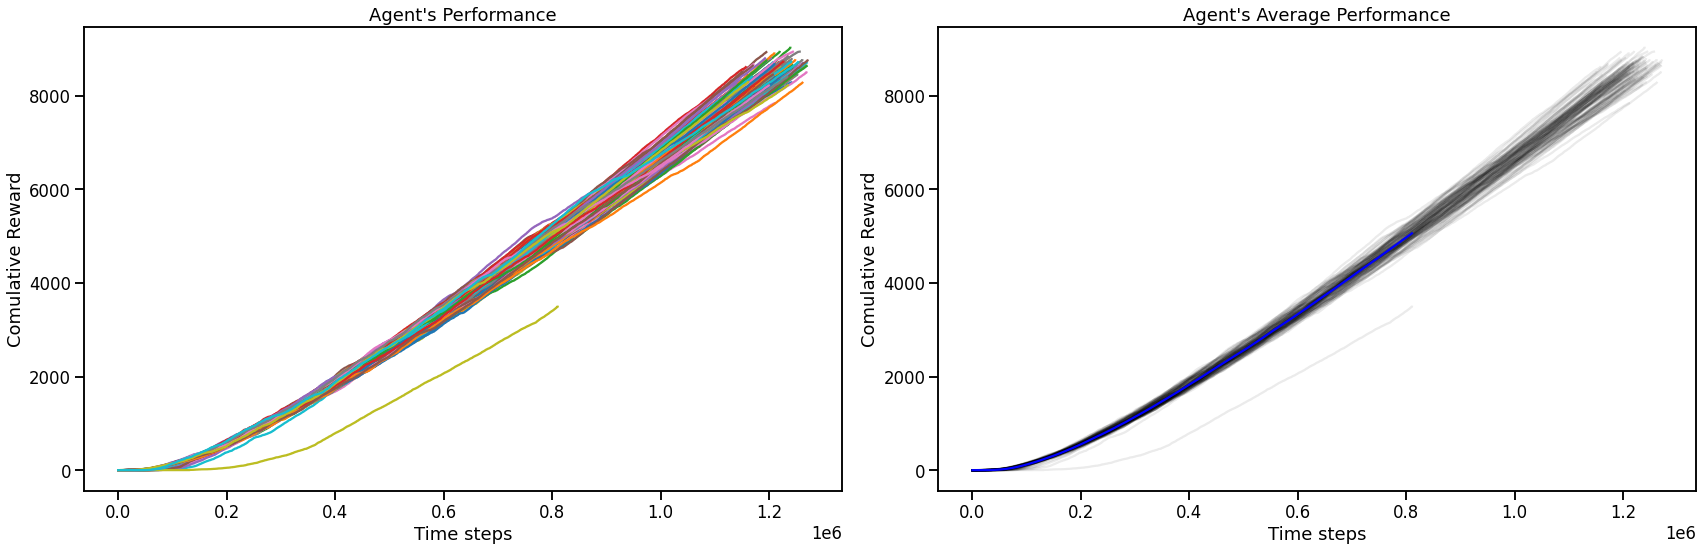

In [14]:
plot_performance(q_learning_results["all_num_steps"], q_learning_results["all_rewards"])

In [15]:
# Get top policy and state-action values
q_learning_policy_performance = test_policies(q_learning_results)

q_learning_top_policy = dict(zip(range(len(list(q_learning_policy_performance)[0])),list(q_learning_policy_performance)[0]))
q_learning_sample_q = get_q_from_policy(q_learning_results, q_learning_top_policy)

100%|██████████| 100/100 [12:38<00:00,  7.59s/it]


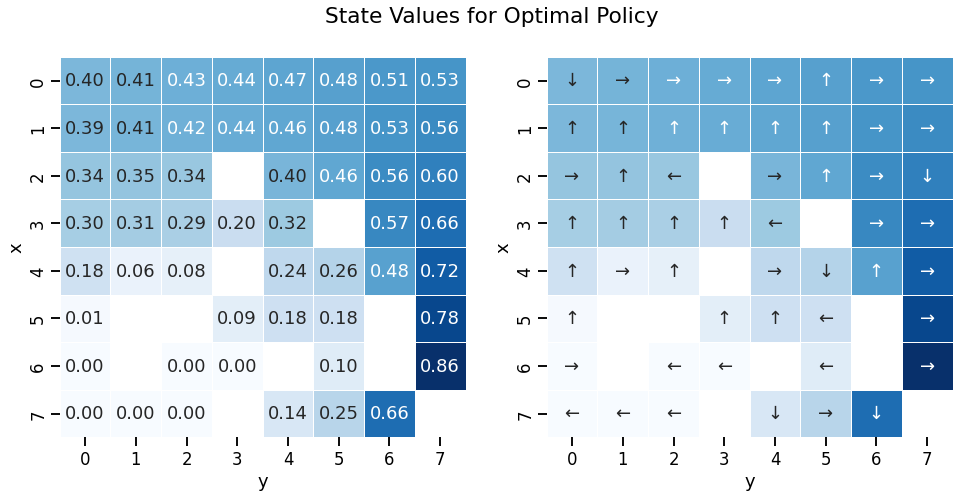

In [16]:
plot_frozen_lake(q_learning_sample_q, terminal_states = terminal_states, size = size)

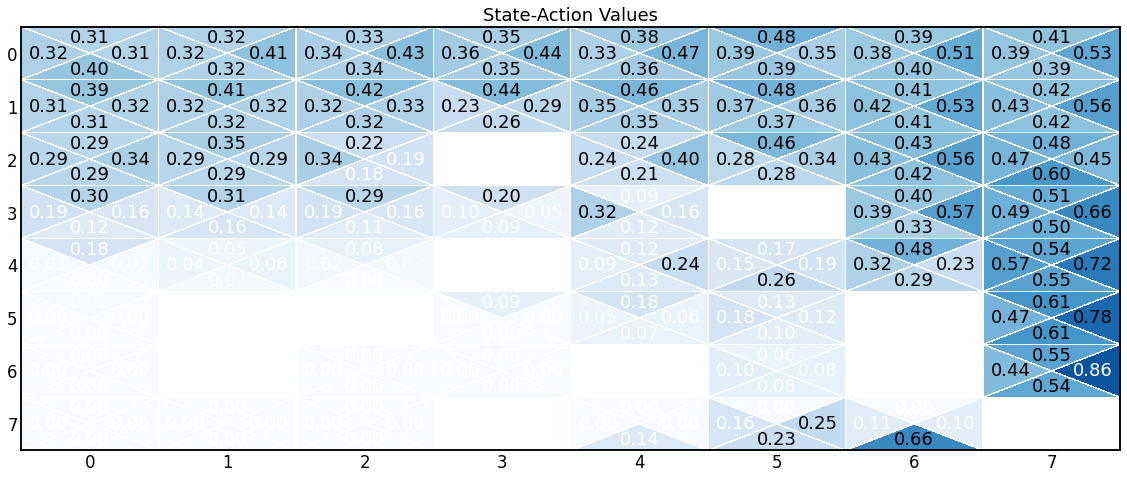

In [17]:
# State-Action values
plot_state_action_frozen_lake(q_learning_sample_q, terminal_states = terminal_states, size = size)

### Expected Sarsa

In [18]:
# Parameters
epsilon = 0.2
alpha = 0.1
gamma = 0.99

# Agent information
agent_class = ExpectedSarsaAgent
agent_info = {"num_actions": env.action_space.n, 
              "num_states": env.observation_space.n, 
              "epsilon": epsilon, 
              "alpha": alpha, 
              "gamma": gamma}

# Monte Carlo Exploring Starts results
expected_sarsa_results = {}

# Train Agent
expected_sarsa_results["all_num_steps"], expected_sarsa_results["all_rewards"], expected_sarsa_results["rewards_per_episode"], expected_sarsa_results["all_q"] = train_agent(env, agent_class, agent_info, terminal_states, decay_exploration = True)

100%|██████████| 100/100 [2:12:35<00:00, 79.55s/it] 


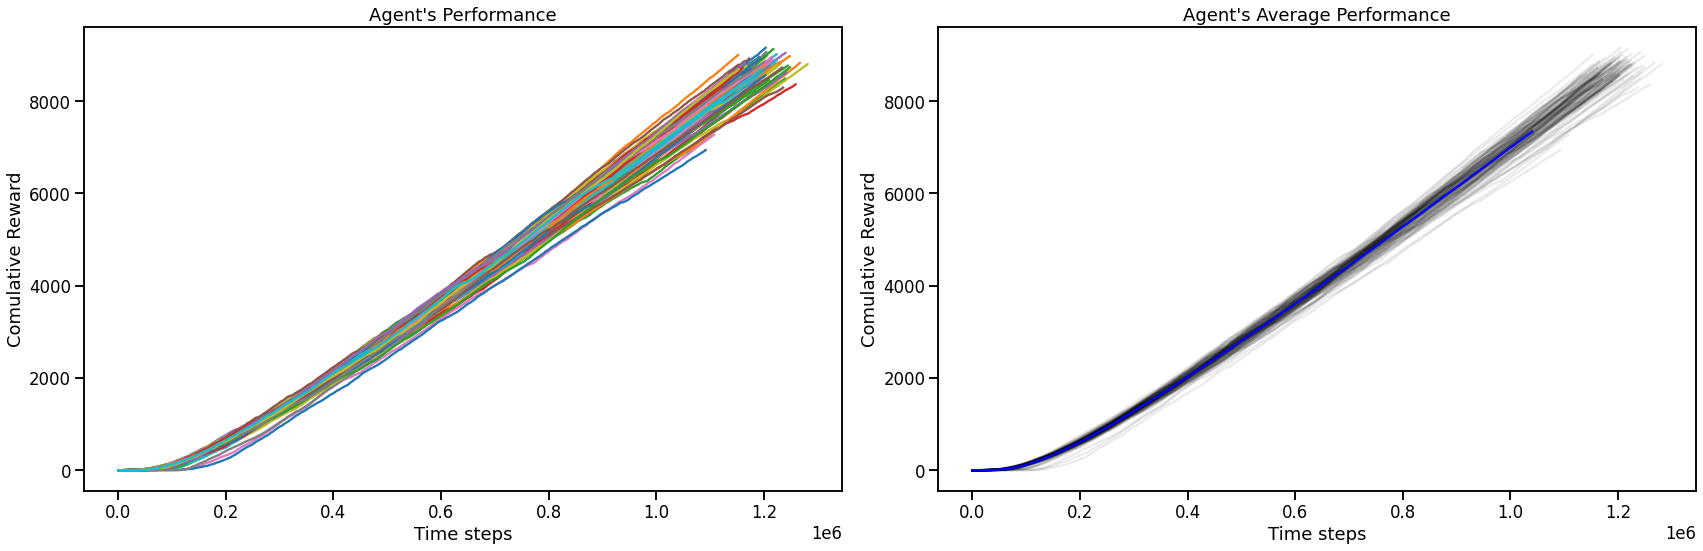

In [19]:
plot_performance(expected_sarsa_results["all_num_steps"], expected_sarsa_results["all_rewards"])

In [20]:
# Get top policy and state-action values
expected_sarsa_policy_performance = test_policies(expected_sarsa_results)

expected_sarsa_top_policy = dict(zip(range(len(list(expected_sarsa_policy_performance)[0])),list(expected_sarsa_policy_performance)[0]))
expected_sarsa_sample_q = get_q_from_policy(expected_sarsa_results, expected_sarsa_top_policy)

100%|██████████| 100/100 [12:34<00:00,  7.54s/it]


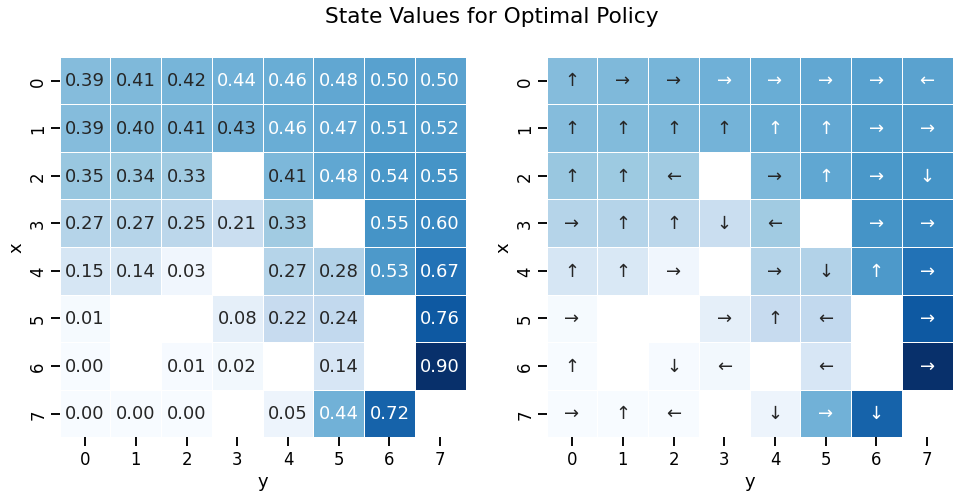

In [21]:
plot_frozen_lake(expected_sarsa_sample_q, terminal_states = terminal_states, size = size)

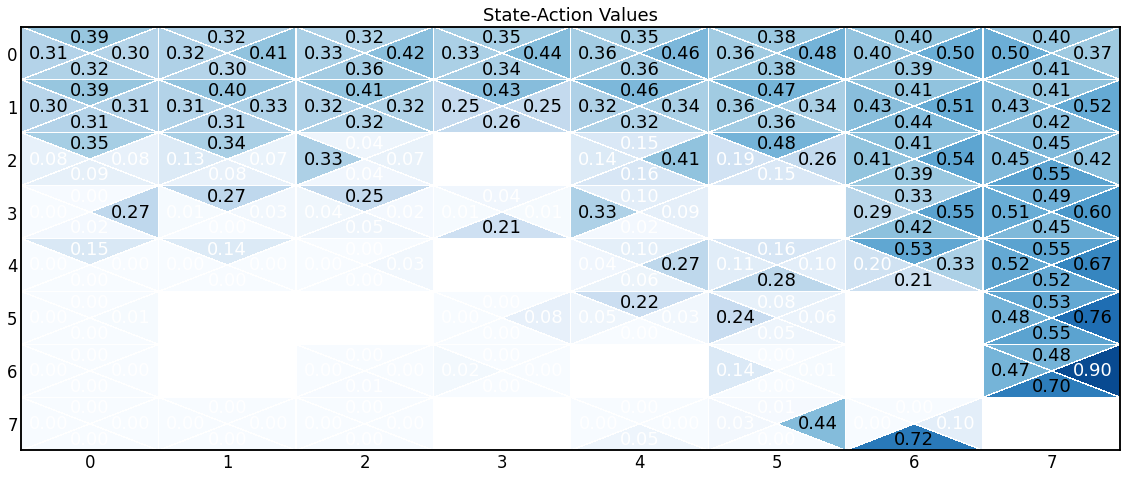

In [22]:
plot_state_action_frozen_lake(expected_sarsa_sample_q, terminal_states = terminal_states, size = size)

## Comparing Algorithms

It is important to note that Monte Carlo Exploring Starts starts in a random position rather than the real starting position, so for a fair comparison only Q-Learning and Expected Sarsa could be compared head to head.

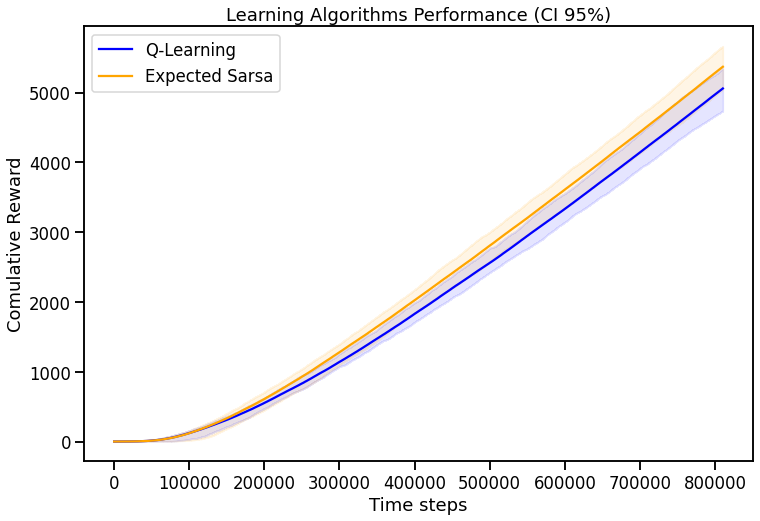

In [23]:
compare_alogrithms = {"Q-Learning": q_learning_results,
                      "Expected Sarsa": expected_sarsa_results, 
                      #"Monte Carlo ES": monte_carlo_results,
                      }

# Create color dict
color_dict = {"Q-Learning": 'blue',
              "Expected Sarsa": 'orange', 
              "Monte Carlo ES": 'red',
              "Dyna-Q": 'green',
              "Dyna-Q Plus": 'purple', 
             }

min_steps = float('inf')

for algorithm in compare_alogrithms:
    for l in compare_alogrithms[algorithm]["all_num_steps"]:
        min_steps = min(min_steps, len(l))


# Plot Comparisson
fig, ax = plt.subplots()

for idx, algorithm in enumerate(compare_alogrithms):

    truncated_all_rewards = [a[:min_steps] for a in compare_alogrithms[algorithm]["all_rewards"]]

    lower = np.percentile(truncated_all_rewards, 2.5, axis=0)
    upper = np.percentile(truncated_all_rewards, 97.5, axis=0)

    ax.plot(np.arange(min_steps), np.array(truncated_all_rewards).mean(axis=0), label=algorithm, color = color_dict[algorithm])
    ax.fill_between(np.arange(min_steps), lower, upper, color = color_dict[algorithm], alpha=.1)

ax.legend()

ax.set_title('Learning Algorithms Performance (CI 95%)')
ax.set_xlabel("Time steps")
ax.set_ylabel("Comulative Reward")

plt.show()

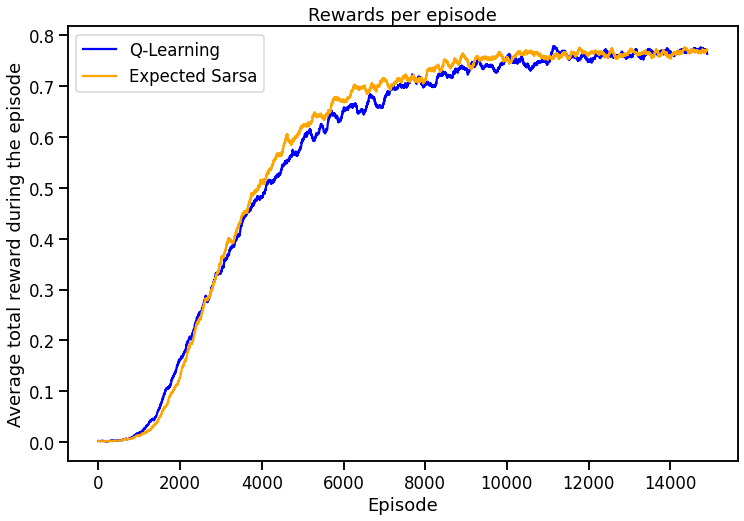

In [24]:
compare_alogrithms = {"Q-Learning": q_learning_results,
                      "Expected Sarsa": expected_sarsa_results, 
                      #"Monte Carlo ES": monte_carlo_results
                      }

# Plot Comparisson
fig, ax = plt.subplots()

# Moving Average
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

for idx, algorithm in enumerate(compare_alogrithms):

    average_score = np.array(compare_alogrithms[algorithm]['rewards_per_episode']).reshape(num_runs, num_episodes).mean(axis=0)
    moving_average_score = moving_average(average_score, 100)

    ax.plot(np.arange(len(moving_average_score)), moving_average_score, label=algorithm, color = color_dict[algorithm])

ax.legend()

ax.set_title('Rewards per episode')
ax.set_xlabel("Episode")
ax.set_ylabel("Average total reward during the episode")

plt.show()

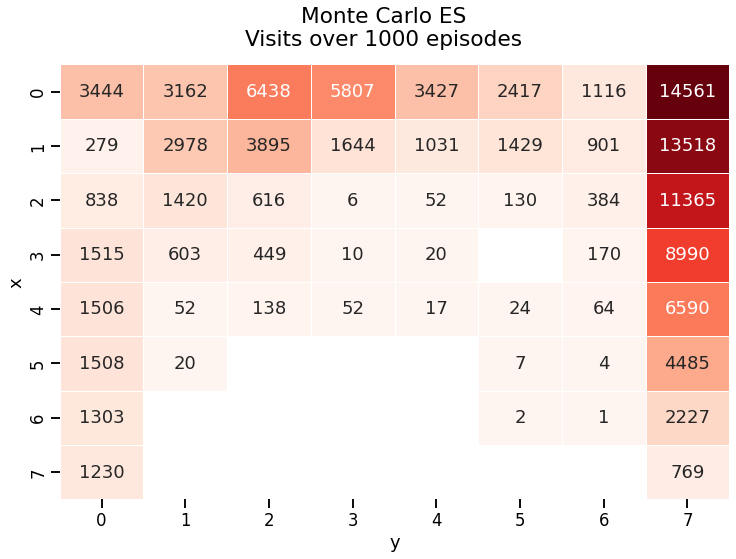

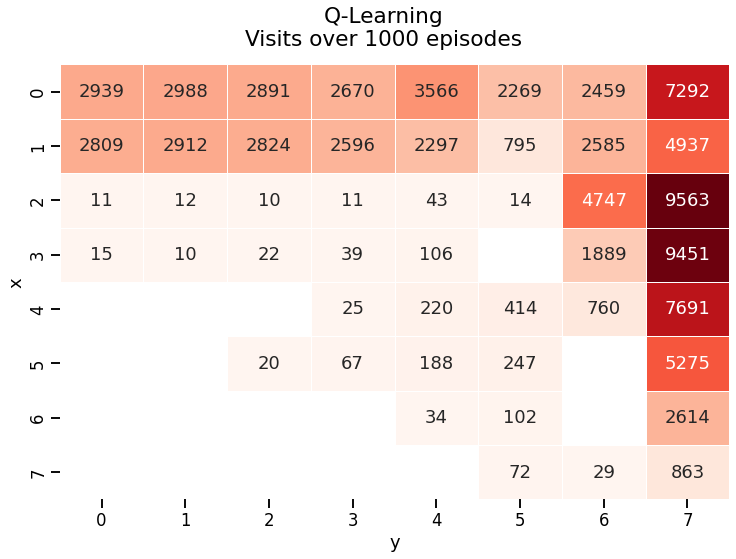

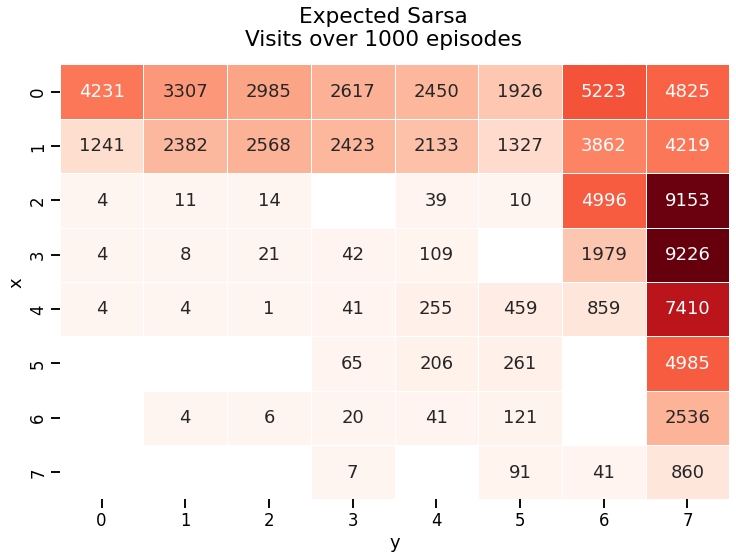

In [25]:
# Set number of games
num_games = 1000

all_policies = {"Monte Carlo ES": monte_carlo_top_policy,
                "Q-Learning": q_learning_top_policy,
                "Expected Sarsa": expected_sarsa_top_policy,
                }


for policy_name in all_policies:


    policy = all_policies[policy_name]
    states = []

    for _ in range(num_games):

        # Reset env
        env.reset()
        state = env.s
        states.append(state)

        # Initial action
        action = policy[state]
        done = False

        while not done:

            new_state, reward, done, _ = env.step(action)
            new_action = policy[new_state]

            # Update state and action
            state, action = new_state, new_action
            states.append(state)

    counter = dict(collections.Counter(states))

    freqs = pd.DataFrame.from_dict(counter, orient='index').reset_index().rename(columns={'index':"state", 0:"freq"})
    freqs["x"] = freqs["state"].apply(lambda x: x//size[0])
    freqs["y"] = freqs["state"].apply(lambda x: x%size[1])

    # Reshape Data
    returns = freqs.pivot("x", "y", "freq")

    # Plot
    fig, axes = plt.subplots()
    fig.suptitle(f'{policy_name}\nVisits over {num_games} episodes')

    sns.heatmap(returns, annot=True, linewidths=.5, cbar=False, cmap="Reds",fmt='g');

In [26]:
# Set number of games

num_reps = 1000
num_games = 100

all_policies = {"Monte Carlo ES": monte_carlo_top_policy,
                "Q-Learning": q_learning_top_policy,
                "Expected Sarsa": expected_sarsa_top_policy, 
                }

results = {}
results_steps = {}


for policy_name in all_policies:

    results[policy_name] = []
    results_steps[policy_name] = []

    for _ in range(num_reps):

        cum_reward = 0
        num_steps = 0

        policy = all_policies[policy_name]

        for _ in range(num_games):

            # Reset env
            env.reset()
            state = env.s

            # Initial action
            action = policy[state]
            done = False

            while not done:

                new_state, reward, done, _ = env.step(action)
                new_action = policy[new_state]

                # Update reward
                num_steps += 1
                cum_reward += reward

                # Update state and action
                state, action = new_state, new_action

        results[policy_name].append(cum_reward/num_games)
        results_steps[policy_name].append(cum_reward/num_steps)


    print("Average reward for {}: {:.4f}, SD={:.4f}".format(policy_name, np.mean(results[policy_name]), np.std(results[policy_name]) ))
    print("Average reward per step for {}: {:.4f}, SD={:.4f}".format(policy_name, np.mean(results_steps[policy_name]), np.std(results_steps[policy_name]) ))

Average reward for Monte Carlo ES: 0.7609, SD=0.0438
Average reward per step for Monte Carlo ES: 0.0068, SD=0.0006
Average reward for Q-Learning: 0.8726, SD=0.0327
Average reward per step for Q-Learning: 0.0093, SD=0.0006
Average reward for Expected Sarsa: 0.8744, SD=0.0324
Average reward per step for Expected Sarsa: 0.0097, SD=0.0007


## Effect of Learning Rate

In [29]:
# Number of runs and episodes per run
num_runs = 1
num_episodes = 15000

# Fix Parameters
epsilon = 0.05 # Not used if decay_exploration=True
gamma = 1

agents = {"Q-Learning": QLearningAgent, "Expected Sarsa": ExpectedSarsaAgent}
alphas = np.arange(0.1, 1.0, 0.1)

lr_result = {}

for agent in agents:

    lr_result[agent] = {}

    for alpha in alphas:

        lr_result[agent][alpha] = {}

        agent_class = agents[agent]
        
        # Agent information
        agent_info = {"num_actions": env.action_space.n, 
                    "num_states": env.observation_space.n, 
                    "epsilon": epsilon, 
                    "alpha": alpha, 
                    "gamma": gamma}

        # Train agent
        lr_result[agent][alpha]["all_num_steps"], lr_result[agent][alpha]["all_rewards"], lr_result[agent][alpha]["rewards_per_episode"], lr_result[agent][alpha]["all_q"] = train_agent(env, agent_class, agent_info, terminal_states, decay_exploration=True)

100%|██████████| 1/1 [01:30<00:00, 90.92s/it]


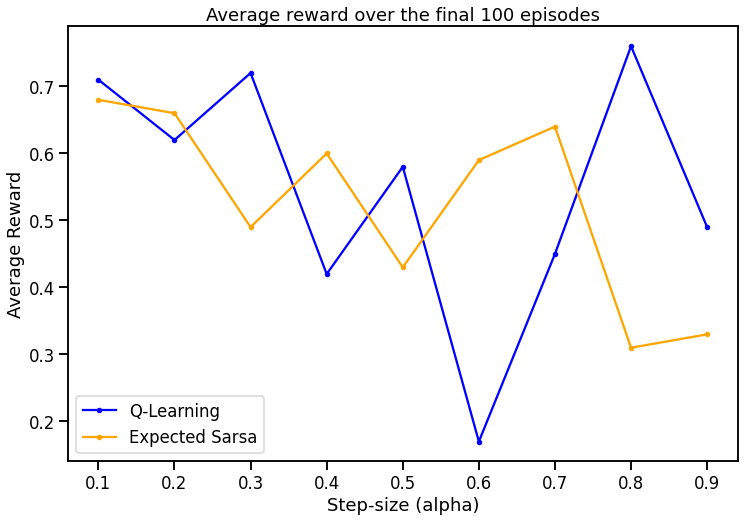

In [30]:
# Plot Comparisson
fig, ax = plt.subplots()

for idx, agent in enumerate(agents):

    all_rewards = []
    all_std = []

    for alpha in alphas: 

        average_rewards = np.array(lr_result[agent][alpha]["rewards_per_episode"]).reshape(num_runs, num_episodes)[:,-100:].mean(axis=1)
        
        average_reward = average_rewards.mean()
        std_reward = np.std(average_rewards)

        all_rewards.append(average_reward)
        all_std.append(std_reward)

    ax.plot(alphas, all_rewards, label=agent, color = color_dict[agent], marker=".")
    ax.fill_between(alphas, np.array(all_rewards)-np.array(all_std), np.array(all_rewards)+np.array(all_std), color = color_dict[agent], alpha=.1)

ax.legend()

plt.xticks(alphas)

ax.set_title('Average reward over the final 100 episodes')
ax.set_xlabel("Step-size (alpha)")
ax.set_ylabel("Average Reward")

plt.show()


Carlo di Francescantonio - Factored 2022